# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
from sklearn.model_selection import train_test_split

In [3]:
import nltk
import nltk.corpus
from nltk.corpus import stopwords, wordnet, words
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping

# Data

In [5]:
df = pd.read_csv('C:/Users/jessi/tswift_lyrics/genius_lyrics_collection/tswift_lyrics.csv')
df.head()

,Album,Song Name,Lyrics
0,Taylor Swift,A Perfectly Good Heart,why would you wanna break a perfectly good hea...
1,Taylor Swift,A Place In This World,i dont know what i want so dont ask me cause i...
2,Taylor Swift,Cold as You,you have a way of coming easily to me and when...
3,Taylor Swift,I'm Only Me When I'm With You,friday night beneath the stars in a field behi...
4,Taylor Swift,Invisible,she cant see the way your eyes light up when y...


In [6]:
# join 'Lyrics' column into single string
lyric_text = ' '.join(df['Lyrics'])

# Train Model

In [7]:
# training tokenizer on lyric_text
tokenizer = Tokenizer()
tokenizer.fit_on_texts([lyric_text])

# creating vocabulary
total_words = len(tokenizer.word_index) + 1

In [8]:
# create input sequences
input_sequences = []
for line in df['Lyrics']:
    # convert words into corresponding tokens
    token_list = tokenizer.texts_to_sequences([line])[0]
    # print(token_list)
    for i in range(1, len(token_list)):
        # create n-gram sequences from tokens
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

print('Total Input Sequences: ', len(input_sequences))

Total Input Sequences:  84261


In [9]:
# find lyric that has max length
max_sequence_len = max([len(x) for x in input_sequences])

# based on that length, pad the rest of input sequences to have equal length
input_sequences = np.array(pad_sequences(
    input_sequences,
    maxlen=max_sequence_len,
    padding='pre'))

#input_sequences[1]

In [10]:
# create features and label
# Xs = predictors; ys = output
Xs, labels = input_sequences[:, :-1], input_sequences[:, -1]

# convert class vector to binary class matrix
labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

print(Xs[5])
print(labels[5])
#print(ys[5][14])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

In [11]:
# split data
X_train, X_val, y_train, y_val = train_test_split(Xs, labels, test_size=0.25, random_state=42)

In [12]:
class Perplexity(Callback):
    def on_epoch_end(self, epoch, logs={}):
        cross_entropy = logs.get('loss')
        perplexity = np.exp(cross_entropy)
        print(f' - perplexity: {perplexity}')
        
def train(model):
    # stop training pocess early if model stops improving
    earlystop = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1,
                              mode='auto',
                              restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=100,
                        validation_data=(X_val, y_val),
                        callbacks=[earlystop, Perplexity()])
    return history

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.show()

## Baseline Model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1975/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0471 - loss: 6.3444 - perplexity: 424.6712361696383
1975/1975 ━━━━━━━━━━━━━━━━━━━━ 3453s 2s/step - accuracy: 0.0471 - loss: 6.3443 - val_accuracy: 0.0855 - val_loss: 5.6697
Epoch 2/100
1975/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0997 - loss: 5.3963 - perplexity: 205.9803392234109
1975/1975 ━━━━━━━━━━━━━━━━━━━━ 3499s 2s/step - accuracy: 0.0997 - loss: 5.3962 - val_accuracy: 0.1301 - val_loss: 5.3067
Epoch 3/100
1975/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1504 - loss: 4.8561 - perplexity: 126.2320514128348
1975/1975 ━━━━━━━━━━━━━━━━━━━━ 3116s 2s/step - accuracy: 0.1504 - loss: 4.8560 - val_accuracy: 0.1678 - val_loss: 5.0854
Epoch 4/100
1975/1975 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1898 - loss: 4.4211 - perplexity: 82.222859940758
1975/1975 ━━━━━━━━━━━━━━━━━━━━ 2903s 1s/step - accuracy: 0.1898 - loss: 4.4211 - val_accuracy: 0.1897 - val_loss: 4.9367
Epoch 5/100
1975/1975 ━━━━━━━━━━━━━━━━

C:\Users\jessi\AppData\Local\Temp\ipykernel_1880\1361016758.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


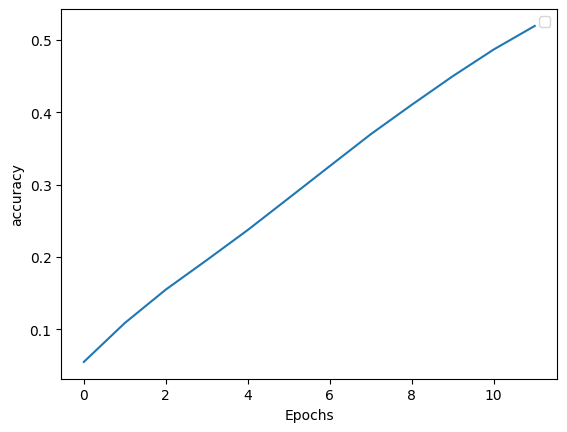

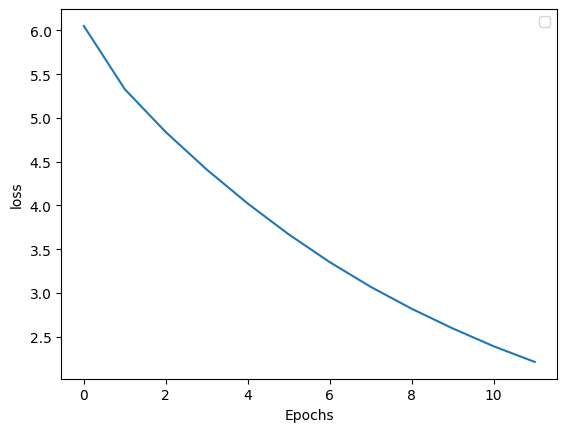

In [13]:
baseline_model = Sequential()
# input or embedding layer: transforms input data into dense layers of fixed size (100-D vector)
baseline_model.add(Embedding(total_words, 100)) 
# LSTM layer: 150 LSTM units work to understand the sequence and context of words
baseline_model.add(LSTM(150))
# dropout layer: randomly skips some neurons during training to avoid overfitting
# makes model less sensitive to sensitive to weights of neurons; set to 0.1 dropout rate
baseline_model.add(Dropout(0.1))
# output or dense layer: prepares model to choose next word
# has as many neurons as there are in vocabulary
baseline_model.add(Dense(total_words, activation='softmax'))
baseline_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

baseline_model.summary()

history = train(baseline_model)

# plot accuracy and loss
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [14]:
# # define and build model
# model = Sequential()
# model.add(Embedding(total_words, 100))
# model.add(Bidirectional(LSTM(150)))
# #model.add(LSTM(128))
# model.add(Dense(total_words, activation='softmax'))
# adam = Adam(learning_rate=0.01)
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# print(model.summary())

In [15]:
# # train model
# history = model.fit(Xs, ys, epochs=50, verbose=1)
# #model.fit(X, y, epochs=500, verbose=1)
# print(model)

# # note: takes about an hour to run!

In [16]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.show()

# Predict Next Word

## Baseline Model

In [17]:
# generate next word predictions
seed_text = 'I am'
next_words = 150

for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list],
                             maxlen=max_sequence_len-1,
                             padding='pre')
  predicted = np.argmax(baseline_model.predict(token_list), axis=-1)
  output_word = ''
  for word, index in tokenizer.word_index.items():
    if index == predicted:
      output_word = word
      break
  seed_text += ' ' + output_word
print(seed_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1